In [1]:
import nltk

In [2]:
from nltk.corpus import genesis

In [3]:
genesis_words = genesis.words()

In [4]:
def filter_letter(let):

    if ord('a') <= ord(let) <= ord('z'):
        return True
    
    else:
        return False

In [5]:
def make_blocks(word_list,block_size):
    word_str = "".join(word_list)
    new_str = ""
    blocked_arr = []



    for i in range(0,len(word_str)):
        
        let = word_str[i].lower()
        if filter_letter(let):
            new_str += let
        else:
            pass
    
    del word_str

    for i in range(0, len(new_str), block_size):
        block = new_str[i:i+block_size]
        
        if len(block) == block_size:
            blocked_arr.append(block)
        else:
            diff = block_size - len(block)
            padded_block = block + "x" * diff
            blocked_arr.append(padded_block)

    return blocked_arr

In [6]:
pt_blocks = make_blocks(genesis_words,8)
print(pt_blocks[:10])

['inthebeg', 'inninggo', 'dcreated', 'theheave', 'nandthee', 'arthandt', 'heearthw', 'aswithou', 'tformand', 'voidandd']


In [7]:
def let2num(let):
    return ord(let.lower()) - ord('a')

def num2let(num):
    return chr(num + ord('a'))


def vigenere(string, key):
    cipher_text = []
    for i in range(len(string)):
        x = (ord(string[i].lower()) + ord(key[i].lower())) % 26
        x += ord('a')
        cipher_text.append(chr(x))
    return ("" . join(cipher_text))


In [8]:
ct_blocks = []
key = 'dontpanc'


FIXED_KEY = 5    
for idx in range(len(pt_blocks)):
    
    ct_t = vigenere(pt_blocks[idx],key)   
    
    ct_blocks.append(ct_t)

In [9]:
print(len(ct_blocks))

134339


In [10]:
print(len(pt_blocks))

134339


In [11]:
pt_blocks[:5]

['inthebeg', 'inninggo', 'dcreated', 'theheave', 'nandthee']

In [12]:
ct_blocks[:5]

['xnsmfndu', 'xnmnosfc', 'scqjbfdr', 'ihdmfmus', 'camiutds']

In [13]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense,InputLayer

In [14]:
batch_size = 64
num_samples = 137957
latent_dim = 256
epochs = 15

In [15]:
input_texts = pt_blocks
target_texts = ct_blocks

In [16]:
# Start token \t
# end token \n

input_characters = set()
target_characters = set()

for i in range(len(input_texts)):

    input_texts[i] = input_texts[i] + '\n'
    
    for char in input_texts[i]:
        if char not in input_characters:
            input_characters.add(char)



for j in range(len(target_texts)):
    target_texts[j] = '\t' + target_texts[j] + '\n'
    
    for char in target_texts[j]:
        if char not in target_characters:
            target_characters.add(char)

In [17]:
unique_chars = set()

for word in pt_blocks:

    for let in word:

        if not let in unique_chars:
            unique_chars.add(let)


print(len(unique_chars))

27


In [18]:
input_characters.add(' ')
target_characters.add(' ')
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))

num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)

max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])


print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 134339
Number of unique input tokens: 28
Number of unique output tokens: 29
Max sequence length for inputs: 9
Max sequence length for outputs: 10


In [19]:
input_token_index = dict([(char, i)
                         for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i)
                          for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype="float32",
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype="float32",
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype="float32",
)

In [20]:
encoder_input_data.shape

(134339, 9, 28)

In [21]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1:, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1:, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

In [22]:
print(encoder_input_data.shape)
print(decoder_target_data.shape)

(134339, 9, 28)
(134339, 10, 29)


In [23]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(
    latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(
    decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [24]:
print(encoder_input_data.shape)
print(num_encoder_tokens)

(134339, 9, 28)
28


In [25]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)
# Save model
model.save("s2s_model.keras")

Epoch 1/15


1680/1680 [==============================] - 74s 42ms/step - loss: 1.9069 - accuracy: 0.4560 - val_loss: 1.2052 - val_accuracy: 0.6499
Epoch 2/15
1680/1680 [==============================] - 64s 38ms/step - loss: 0.5794 - accuracy: 0.8305 - val_loss: 0.3499 - val_accuracy: 0.8873
Epoch 3/15
1680/1680 [==============================] - 68s 40ms/step - loss: 0.1227 - accuracy: 0.9677 - val_loss: 0.1196 - val_accuracy: 0.9633
Epoch 4/15
1680/1680 [==============================] - 66s 39ms/step - loss: 0.0349 - accuracy: 0.9924 - val_loss: 0.0635 - val_accuracy: 0.9813
Epoch 5/15
1680/1680 [==============================] - 72s 43ms/step - loss: 0.0149 - accuracy: 0.9971 - val_loss: 0.0584 - val_accuracy: 0.9820
Epoch 6/15
1680/1680 [==============================] - 72s 43ms/step - loss: 0.0073 - accuracy: 0.9989 - val_loss: 0.0116 - val_accuracy: 0.9975
Epoch 7/15
1680/1680 [==============================] - 69s 41ms/step - loss: 0.0045 - accuracy: 0.9993 - val_loss: 0.0094

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
acc = history.history['accuracy']
loss = history.history['loss']
epochs = list(range(15))

Text(0.5, 1.0, 'Loss vs Epoch')

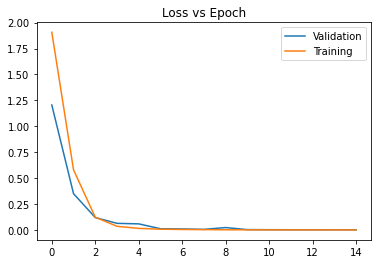

In [30]:
sns.lineplot(x=epochs, y=val_loss, label='Validation')
sns.lineplot(x=epochs, y=loss,label='Training')
plt.legend()
plt.title('Loss vs Epoch')

Text(0.5, 1.0, 'Accuracy vs Epoch')

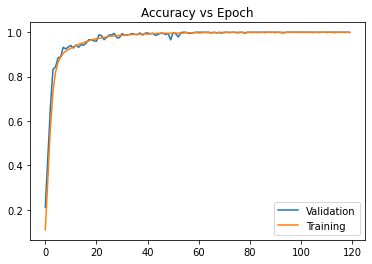

In [ ]:
sns.lineplot(x=epochs, y=val_acc, label='Validation')
sns.lineplot(x=epochs, y=acc, label='Training')
plt.legend()
plt.title('Accuracy vs Epoch')